# Long-Only Strategy using MLFactor Data

In this project you will use the MLFactor data to formulate a trading strategy that you will backtest.

The training data consists of monthly snapshots of variety of fundamental (factor) measurements of a varying number of stocks through time.  These factor measurements will be your features.  The label is a binary variable that indicates whether the stock's return over the next month was above or below the median return - thus we are reducing our problem to one of binary classification.  The training set has data from 2000-2013.  You will be fitting a predictive model to this data.

The testing data consists of the same features for 2014-2018.  It also contains the forward looking one-month return that the stock experienced after the factor snapshot.  You will use the model that you fit using the training data to formulate a long-only strategy on the testing data, and then backtest that strategy.  Your trading strategy will rebalance monthly.  **Note:** You cannot use the one-month returns in the testing data for your decisions regarding which securities to take positions in (that's like looking into the future); you should only use inferences from the model you fit on the trading data.

This project will involve hyperparameter tuning which can take a long time, so start early. If you have access to a GPU, using it will speed up the process substantially for **xgboost**.

**Coding and Analysis (Jupyter Notebooks) -- 200 pts**

1. Perform feature selection where you choose 30-40 features to include in your models.  You will fit your model to both your selected subset as well as the full feature set.

2. You will use three different classifiers: `LogisticRegression`, `RandomForestClassifier`, `XGBClassifier`

3. For each classifier, you will tune 3 hyperparameters; use `GridSearchCV` to do an exhaustive grid search to find the optimal combination of the three hyperparameters. Use accuracy, precision, recall, and ROC-AUC as your scoring metrics. Use 5-fold cross validation.

    - Tune the models using both your chosen subset of features, as well as the full feature set.
    -  Do you notice much of a difference in the optimal parameters when using all the features versus when using the feature subset?


5. After you have choose the optimal hyperparameters from #3, fit the models to your full data set.  You will have six different models:
    - `LogisticRegression` + feature subset
    - `LogisticRegression` + all features
    - `RandomForestClassifier` + feature subset
    - `RadomForestClassifier` + all features
    - `XGBClassifier` + feature subset
    - `XGBClassifier` + all features


6. Using your six different fitted models, create trading strategies and backtest them on the testing data.  Ideally, it will be the same basic strategy, just using the different models for generating the signal to hold a stock or not.  Compare your six models/strategies to each other as well as to the *benchmark* strategy of going long the market in an equally weighted portfolio.  Include the following metrics in your analysis of your strategies:

    - annualized return
    - annualized portfolio volatility
    - sharpe ratio: $\mu/\sigma * \sqrt{12}$ where $\mu$ is the average monthly return and $\sigma$ is the monthly portfolio volatility
    - maximum draw-down
    - worst month

7. Make a conclusion about which model and feature set that you would use to inform your trading strategy.
    

**Grading Rubric:**
- accuracy of results: 100 pts
- code commenting: 50 pts
- readability of notebook: 50 pts

**Presentation -- 100 pts**

1. Create a slide presentation.

2. Give a mildly technical overview of the **xgboost** package.

3. Describe your feature selection process.

4. Talk about the hyperparameters that you chose for each model and why you chose them.  Do you notice much of a difference in the optimal parameters when using all the features versus when using the feature subset?

5. Present the results of your backtest results.
    - Which model/feature set would you use to trade your strategy?
    - Did feature selection seem to help?
    - Do you notice any relationship between your training cross-validation fit scores and strategy performance on the test set?

Your presentation should be about 15 minutes and include visualizations.

In [40]:
import numpy as np
import pandas as pd
import random
import sklearn
import time
import warnings
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, make_scorer
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import LabelBinarizer, label_binarize
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, classification_report



In [71]:
def annualized_return(monthly_returns):
    product_of_returns = (1 + monthly_returns).prod()
    num_months = len(monthly_returns)
    return product_of_returns ** (12 / num_months) - 1

def annualized_volatility(monthly_returns):
    monthly_std = monthly_returns.std()
    return monthly_std * np.sqrt(12)

# Define a function to calculate annualized Sharpe ratio
def annualized_sharpe_ratio(monthly_returns):
    mean_monthly_return = monthly_returns.mean()
    monthly_volatility = monthly_returns.std()
    
    if(monthly_volatility == 0):
        return 0

    # Sharpe ratio calculation
    sharpe_ratio = mean_monthly_return / monthly_volatility
    
    # Annualize the Sharpe ratio
    annualized_sharpe_ratio = sharpe_ratio * np.sqrt(12)
    return annualized_sharpe_ratio

# Define a function to calculate maximum drawdown
def maximum_drawdown(monthly_returns):
    # Calculate cumulative returns (compounded returns)
    cumulative_returns = (1 + monthly_returns).cumprod()
    
    # Calculate the peak up to each point
    peak = cumulative_returns.cummax()
    
    # Calculate the drawdown (difference between peak and cumulative returns)
    drawdown = (cumulative_returns - peak) / peak
    
    # Maximum drawdown is the minimum value of the drawdown
    max_drawdown = drawdown.min()
    
    return max_drawdown

# Define a function to calculate the worst month (minimum return)
def worst_month(monthly_returns):
    return monthly_returns.min()

In [72]:
def run_financial_stats(df_test, ret_col):
    # Group by stock_id and calculate the annualized return for each stock
    annualized_returns = df_test.groupby('stock_id')[ret_col].apply(annualized_return).reset_index()

    # Rename the resulting column
    annualized_returns.columns = ['stock_id', 'annualized_return']

    # Average
    print("Average Annualzied Returns: ", annualized_returns['annualized_return'].sum()/len(annualized_returns))

    # Group by stock_id and calculate annualized volatility for each stock
    annualized_volatilities = df_test.groupby('stock_id')[ret_col].apply(annualized_volatility).reset_index()

    # Rename the resulting column
    annualized_volatilities.columns = ['stock_id', 'annualized_volatility']

    # Average
    print("Average Annualzied Vol: ", annualized_volatilities['annualized_volatility'].sum()/len(annualized_volatilities))

    # Group by stock_id and calculate the annualized Sharpe ratio for each stock
    annualized_sharpe_ratios = df_test.groupby('stock_id')[ret_col].apply(annualized_sharpe_ratio).reset_index()

    # Rename the resulting column
    annualized_sharpe_ratios.columns = ['stock_id', 'annualized_sharpe_ratio']

    # Average
    print("Average Annualzied Sharpe Ratio: ", annualized_sharpe_ratios['annualized_sharpe_ratio'].sum()/len(annualized_sharpe_ratios))

    # Group by stock_id and calculate maximum drawdown for each stock
    max_drawdowns = df_test.groupby('stock_id')[ret_col].apply(maximum_drawdown).reset_index()

    # Rename the resulting column
    max_drawdowns.columns = ['stock_id', 'max_drawdown']

    # Average
    print("Average Max Drawdown: ", max_drawdowns['max_drawdown'].sum()/len(max_drawdowns))

    # Group by stock_id and calculate the worst month for each stock
    worst_months = df_test.groupby('stock_id')[ret_col].apply(worst_month).reset_index()

    # Rename the resulting column
    worst_months.columns = ['stock_id', 'worst_month_return']

    # Average
    print("Average Worst Month: ", worst_months['worst_month_return'].sum()/len(worst_months))

In [67]:
df_train = pd.read_csv('/Users/yuanhanlim/Desktop/11102024mlfactorzip/Homework 11, Project 3/mlfactor_project_training.csv')
df_train_y = df_train['R1M_Usd_C']
df_train = pd.read_csv('/Users/yuanhanlim/Desktop/11102024mlfactorzip/Homework 11, Project 3/mlfactor_selected_features_train.csv')
df_train_X = df_train.iloc[:,1:]

In [68]:
df_test = pd.read_csv('/Users/yuanhanlim/Desktop/11102024mlfactorzip/Homework 11, Project 3/mlfactor_project_testing.csv')

df_test_X = df_test[df_train.columns.intersection(df_test.columns)]
df_test_y = df_test['R1M_Usd']


In [69]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression on df_train_X and binary df_train_y
model = LogisticRegression()
model.fit(df_train_X, df_train_y)

# Predict binary outcomes on df_test_X
y_pred = model.predict(df_test_X)

# Multiply predictions with continuous df_test_y values
df_test['Logistic'] = y_pred * df_test_y  # Retains values where y_pred is 1, otherwise 0

# Calculate evaluation metrics
# Option 1: Total sum of predicted values
predicted_sum = df_test['Logistic'].sum()
actual_sum = df_test_y.sum()
print("Predicted Sum:", predicted_sum)
print("Actual Sum:", actual_sum)

Predicted Sum: 289.455
Actual Sum: 517.1560000000001


In [73]:
run_financial_stats(df_test, 'Logistic')

Average Annualzied Returns:  0.013604766520411647
Average Annualzied Vol:  0.22010779297906868
Average Annualzied Sharpe Ratio:  0.1867770272410154
Average Max Drawdown:  -0.26452251618455674
Average Worst Month:  -0.1482093802345059


,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,...,Ta,Tev_Less_Mktcap,Tot_Debt_Rev,Total_Capital,Total_Debt,Total_Debt_Capital,Total_Liabilities_Total_Assets,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd
0,17,2015-03-31,0.73,0.64,0.70,0.40,0.47,0.01,0.70,0.74,...,0.42,0.81,0.69,0.40,0.75,1.00,1.00,1.00,0.99,0.174
1,17,2015-04-30,0.72,0.62,0.66,0.40,0.46,0.01,0.70,0.74,...,0.42,0.80,0.69,0.40,0.75,1.00,1.00,1.00,0.99,-0.106
2,17,2015-05-31,0.71,0.63,0.64,0.40,0.47,0.01,0.70,0.74,...,0.42,0.81,0.69,0.40,0.75,1.00,1.00,1.00,0.99,-0.185
3,17,2015-06-30,0.70,0.62,0.63,0.38,0.43,0.01,0.53,0.66,...,0.39,0.79,0.69,0.25,0.74,1.00,1.00,1.00,0.99,-0.418
4,17,2015-07-31,0.68,0.56,0.60,0.38,0.45,0.01,0.53,0.66,...,0.39,0.80,0.69,0.25,0.74,1.00,1.00,1.00,0.99,0.575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70484,1158,2018-07-31,0.99,0.99,0.99,0.09,0.85,1.00,0.50,0.50,...,1.00,1.00,0.93,1.00,1.00,0.79,0.90,0.43,0.27,0.028
70485,1158,2018-08-31,0.99,0.99,0.99,0.09,0.85,1.00,0.50,0.50,...,1.00,1.00,0.93,1.00,1.00,0.79,0.90,0.42,0.25,-0.101
70486,1158,2018-09-30,0.99,0.99,0.99,0.09,0.78,1.00,0.03,0.03,...,1.00,1.00,0.93,1.00,1.00,0.79,0.89,0.45,0.26,0.013
70487,1158,2018-10-31,0.99,0.99,0.99,0.09,0.76,1.00,0.03,0.03,...,1.00,1.00,0.93,1.00,1.00,0.79,0.89,0.40,0.26,0.039


In [34]:
from sklearn.linear_model import Lasso

initial_alpha = lasso_cv.alpha_  # Start from the alpha chosen by LassoCV
alpha = initial_alpha
tolerance = 1e-4  # Small step size to adjust alpha
min_features, max_features = 30, 40

# Loop to find an alpha that results in the desired feature count
for i in range(100):  # Limit to 100 iterations to prevent infinite loop
    feature_count, lasso_model = get_feature_count(alpha, data_features, data_label)
    
    if min_features <= feature_count <= max_features:
        print(f"Optimal alpha: {alpha}")
        print(f"Selected features: {feature_count}")
        break
    
    # Adjust alpha based on feature count
    if feature_count > max_features:
        alpha += tolerance  # Increase alpha to reduce features
    else:
        alpha -= tolerance  # Decrease alpha to include more features

# If loop completes without break, adjust tolerance or range of alpha
if feature_count < min_features or feature_count > max_features:
    print("Adjust tolerance or try a wider range of initial alphas.")

final_lasso_model = lasso_model


NameError: name 'lasso_cv' is not defined

In [35]:
# Fit Lasso model with cross-validation
lasso = LassoCV(alphas=[0.0001], tol=0.0001, cv = 5, max_iter = 100000).fit(data_features,data_label)

# Get feature importance (absolute values of coefficients)
feature_importance = np.abs(lasso.coef_)

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': data_features.columns,
    'Importance': feature_importance
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)


              Feature  Importance
44         Mom_5M_Usd    0.067039
70                 Pb    0.060861
74  Return_On_Capital    0.050267
46   Mom_Sharp_5M_Usd    0.035814
30         Fcf_Margin    0.032569
..                ...         ...
64             Ocf_Ta    0.000000
63             Ocf_Oa    0.000000
62            Ocf_Noa    0.000000
61         Ocf_Margin    0.000000
0        Advt_12M_Usd    0.000000

[93 rows x 2 columns]


In [39]:
top_39_features = feature_importance_df[:30]
# Get the list of top 30 feature names
top_39_feature_names = top_39_features['Feature']

# Filter data_features to include only these top 30 features
data_features_top_39 = data_features[top_39_feature_names]

# Initialize and train the logistic regression model on the full dataset
log_reg = LogisticRegression(max_iter=10000, random_state=0)
log_reg.fit(data_features_top_39, data_label)

# Make predictions on the same dataset
y_pred = log_reg.predict(data_features_top_39)

# Evaluate the model on the full dataset
accuracy = accuracy_score(data_label, y_pred)
report = classification_report(data_label, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)


Accuracy: 0.5239254507803425
Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      0.55      0.54     99560
         1.0       0.52      0.49      0.51     98430

    accuracy                           0.52    197990
   macro avg       0.52      0.52      0.52    197990
weighted avg       0.52      0.52      0.52    197990



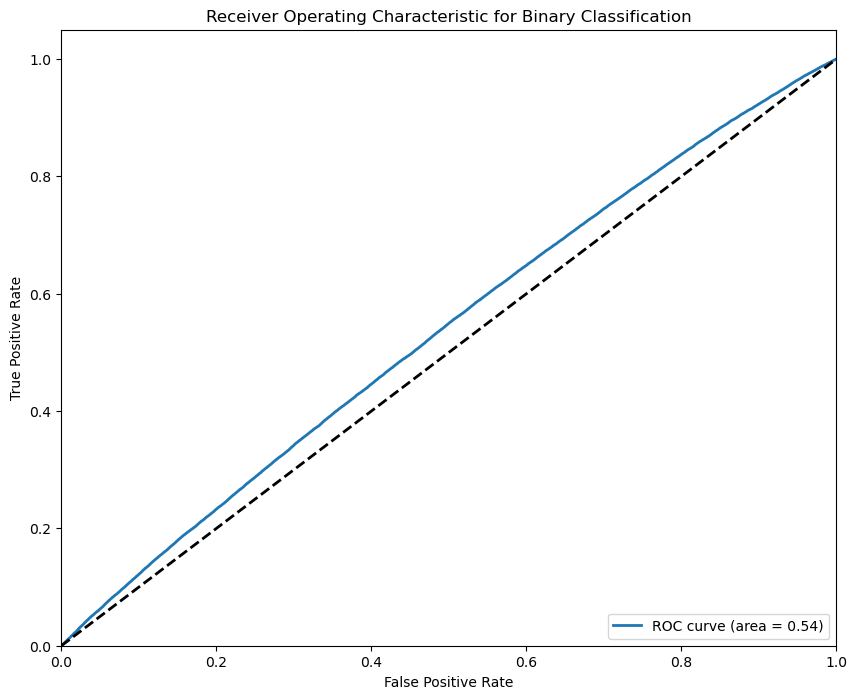

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

# Initialize a matplotlib figure for ROC curves
plt.figure(figsize=(10, 8))

# Create and train the logistic regression model on the full dataset
model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(data_features_top_39, data_label)

# Predict probabilities for AUC-ROC
y_prob = model.predict_proba(data_features_top_39)[:, 1]  # Use probabilities for the positive class

# Compute ROC curve
fpr, tpr, _ = roc_curve(data_label, y_prob)
roc_auc = roc_auc_score(data_label, y_prob)

# Plot ROC curve
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Binary Classification')
plt.legend(loc="lower right")
plt.show()
